In [4]:
! python -m pip install wget
! python -m pip install chmod
! python -m pip install bash
! python -m pip install conda
! python -m pip install pandas
! python -m pip install rdkit
! python -m pip install seaborn
! python -m pip install matplotlib
! python -m pip install scipy.stats


[notice] A new release of pip is available: 23.1.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


ERROR: Could not find a version that satisfies the requirement conda (from versions: 3.0.6, 3.5.0, 3.7.0, 3.17.0, 4.0.0, 4.0.1, 4.0.2, 4.0.3, 4.0.4, 4.0.5, 4.0.7, 4.0.8, 4.0.9, 4.1.2, 4.1.6, 4.2.6, 4.2.7, 4.3.13, 4.3.16)
ERROR: No matching distribution found for conda

[notice] A new release of pip is available: 23.1.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


ERROR: Could not find a version that satisfies the requirement scipy.stats (from versions: none)
ERROR: No matching distribution found for scipy.stats

[notice] A new release of pip is available: 23.1.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
! conda install -c rdkit rdkit -y
import sys
import pandas as pd

import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt
from numpy.random import seed
from numpy.random import randn
from scipy.stats import mannwhitneyu
sys.path.append('/usr/local/lib/python3.7/site-packages/')

'wget' is not recognized as an internal or external command,
operable program or batch file.
'chmod' is not recognized as an internal or external command,
operable program or batch file.
'bash' is not recognized as an internal or external command,
operable program or batch file.
'conda' is not recognized as an internal or external command,
operable program or batch file.


ModuleNotFoundError: No module named 'scipy'

## Load bioactivity data

In [ ]:
! wget https://raw.githubusercontent.com/dataprofessor/data/master/acetylcholinesterase_03_bioactivity_data_curated.csv

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [22]:
df = pd.read_csv('acetylcholinesterase_03_bioactivity_data_curated.csv')


In [ ]:
df_no_smiles = df.drop(columns='canonical_smiles')
     

smiles = []

for i in df.canonical_smiles.tolist():
  cpd = str(i).split('.')
  cpd_longest = max(cpd, key = len)
  smiles.append(cpd_longest)

smiles = pd.Series(smiles, name = 'canonical_smiles')
     

df_clean_smiles = pd.concat([df_no_smiles,smiles], axis=1)
print(df_clean_smiles)

     molecule_chembl_id  standard_value         class  \
0          CHEMBL133897           750.0        active   
1          CHEMBL336398           100.0        active   
2          CHEMBL131588         50000.0      inactive   
3          CHEMBL130628           300.0        active   
4          CHEMBL130478           800.0        active   
...                 ...             ...           ...   
6637      CHEMBL5398421         46000.0      inactive   
6638        CHEMBL11298         38310.0      inactive   
6639      CHEMBL5395312          1710.0  intermediate   
6640      CHEMBL5399112         10000.0      inactive   
6641      CHEMBL5402411         10000.0      inactive   

                                       canonical_smiles  
0                 CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1  
1            O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1  
2     CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1  
3         O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F  
4             CSc1nc(-c2c

Calculate Lipinski descriptors
Christopher Lipinski, a scientist at Pfizer, came up with a set of rule-of-thumb for evaluating the druglikeness of compounds. Such druglikeness is based on the Absorption, Distribution, Metabolism and Excretion (ADME) that is also known as the pharmacokinetic profile. Lipinski analyzed all orally active FDA-approved drugs in the formulation of what is to be known as the Rule-of-Five or Lipinski's Rule.

The Lipinski's Rule stated the following:

Molecular weight < 500 Dalton
Octanol-water partition coefficient (LogP) < 5
Hydrogen bond donors < 5
Hydrogen bond acceptors < 10

Descriptors.MolWt: Calculates the molecular weight.
Descriptors.MolLogP: Computes the octanol-water partition coefficient (logP).
Lipinski.NumHDonors: Determines the number of hydrogen bond donors.
Lipinski.NumHAcceptors: Determines the number of hydrogen bond acceptors

In [24]:

def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors
      

In [28]:
# concat lpinski data to original data frame so each smiles is associated its lipinski data
df_lipinski = lipinski(df_clean_smiles.canonical_smiles)
df_combined = pd.concat([df,df_lipinski], axis=1)

df_combined.head(10)

,molecule_chembl_id,canonical_smiles,standard_value,class,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,750.0,active,312.325,2.80320,0.0,6.0
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,100.0,active,376.913,4.55460,0.0,5.0
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,50000.0,inactive,426.851,5.35740,0.0,5.0
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,300.0,active,404.845,4.70690,0.0,5.0
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,800.0,active,346.334,3.09530,0.0,6.0
5,CHEMBL130112,CSc1nc(-c2ccc(C)cc2)nn1C(=O)N(C)c1ccccc1,2400.0,intermediate,338.436,4.07992,0.0,5.0
6,CHEMBL130098,CSc1nc(-c2ccc(Cl)cc2)nn1C(=O)N(C)C,100.0,active,296.783,2.85010,0.0,5.0
7,CHEMBL337486,CCCCCCSc1nc(-c2ccc(Cl)cc2)nn1C(=O)N1CCOCC1,50000.0,inactive,408.955,4.57120,0.0,6.0
8,CHEMBL336538,COc1ccc(-c2nc(SC)n(C(=O)N(C)C)n2)cc1,800.0,active,292.364,2.20530,0.0,6.0
9,CHEMBL131051,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)c1ccccc1,50000.0,inactive,408.405,4.67010,0.0,6.0


## Convert ic50 to pc1c50
To allow IC50 data to be more uniformly distributed, we will convert IC50 to the negative logarithmic scale which is essentially -log10(IC50).

This custom function pIC50() will accept a DataFrame as input and will:

Take the IC50 values from the standard_value column and converts it from nM to M by multiplying the value by 10
Take the molar value and apply -log10
Delete the standard_value column and create a new pIC50 column

In [33]:

def pIC50(input):
    pIC50 = []

    for i in input['standard_value_norm']:
        molar = i*(10**-9) # Converts nM to M
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop(['standard_value_norm'], axis=1, inplace=False)
        
    return x


# before parsing we want to norm ic50 value since it can be as large as 10^8
def norm_value(input):
    norm = []

    for i in input['standard_value']:
        if i > 100000000:
          i = 100000000
        norm.append(i)

    input['standard_value_norm'] = norm
    x = input.drop(['standard_value'], axis=1, inplace=False)
        
    return x

df_norm = norm_value(df_combined)
df_pIC50 = pIC50(df_norm)

C:\Users\khrli\AppData\Local\Temp\ipykernel_15708\2477987976.py:6: RuntimeWarning: divide by zero encountered in log10
  pIC50.append(-np.log10(molar))


In [ ]:
#Removing the 'intermediate' bioactivity class
# Here, we will be removing the intermediate class from our data set.


df_final = df_pIC50[df_pIC50['class'] != 'intermediate']
df_final.to_csv('acetylcholinesterase_04_bioactivity_data_3class_pIC50.csv')


Plots and statistical significance

Text(0, 0.5, 'pIC50 value')

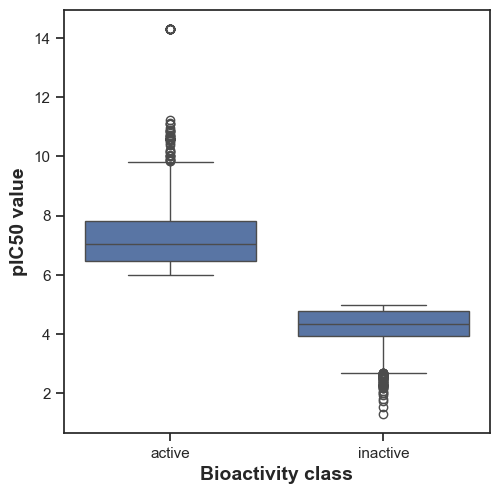

In [36]:
# plotting pc150 in boxplot

plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'pIC50', data = df_final)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')

In [ ]:
# plotting molecular weight in scatter plot

plt.figure(figsize=(5.5, 5.5))
sns.scatterplot(x='MW', y='LogP', data=df_final, hue='class', size='pIC50', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)


c:\Users\khrli\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\colors.py:2294: RuntimeWarning: invalid value encountered in divide
  resdat /= (vmax - vmin)
c:\Users\khrli\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\colors.py:2294: RuntimeWarning: invalid value encountered in divide
  resdat /= (vmax - vmin)


In [6]:
# mann-whiteny u test for stastical analysis
def mannwhitney(descriptor, verbose=False):
  # https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'class']
  df = df_final[selection]
  active = df[df['class'] == 'active']
  active = active[descriptor]

  selection = [descriptor, 'class']
  df = df_final[selection]
  inactive = df[df['class'] == 'inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'
  
  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results

In [7]:
all_statistical_res = []
columns_to_test = ['pIC50', 'MW', 'LogP', 'NumHDonors', 'NumHAcceptors']
for col in columns_to_test:
    result = mannwhitney(col)  # Assuming mannwhitney function returns a dictionary or tuple with stats
    all_statistical_res.append({"Column": col, **result})  # Combine column name with the test result

# Convert the results into a structured DataFrame
statistical_res_df = pd.DataFrame(all_statistical_res)

# Display the result
print(statistical_res_df)





NameError: name 'df_final' is not defined